# Contextual linear bandit with Thompson sampling

In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax.scipy.stats import beta
from jax import random
from jax.nn import one_hot

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Context-free multi-armed Bernoulli bandit

In [4]:
def thompson_sampling_step(state, key):
    alphas, betas, probs = state
    keys = key
    K = len(alphas)
    
    # Choose an arm to pull
    # (Sample from the policy distribution)
    theta_t = random.beta(key, alphas, betas).argmax()
    # Pull the arm and observe reward (either 1 or 0)
    reward = random.bernoulli(key, probs[theta_t])
    
    # Update policy distribution
    ind_vector = one_hot(theta_t, K)
    alphas_posterior = alphas + ind_vector * reward
    betas_posterior = betas + ind_vector * (1 - reward)
    
    return (alphas_posterior, betas_posterior, probs), (alphas_posterior, betas_posterior)

In [5]:
T = 200
key = random.PRNGKey(314)
keys = random.split(key, T)
probs = jnp.array([0.65, 0.4, 0.5, 0.9])
#probs = jnp.ones(5) * 0.5
K = len(probs)


alpha_priors = jnp.ones(K) * 1
beta_priors = jnp.ones(K) * 1

init_state = (alpha_priors, beta_priors, probs)
posteriors, hist = jax.lax.scan(thompson_sampling_step, init_state, keys)
alpha_posterior, beta_posterior, _ = posteriors
alpha_hist, beta_hist = hist

alpha_posterior, beta_posterior

(DeviceArray([  8.,   9.,  18., 140.], dtype=float32),
 DeviceArray([ 4.,  7., 11., 11.], dtype=float32))

In [6]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], alpha_hist[None, ...], beta_hist[None, ...])

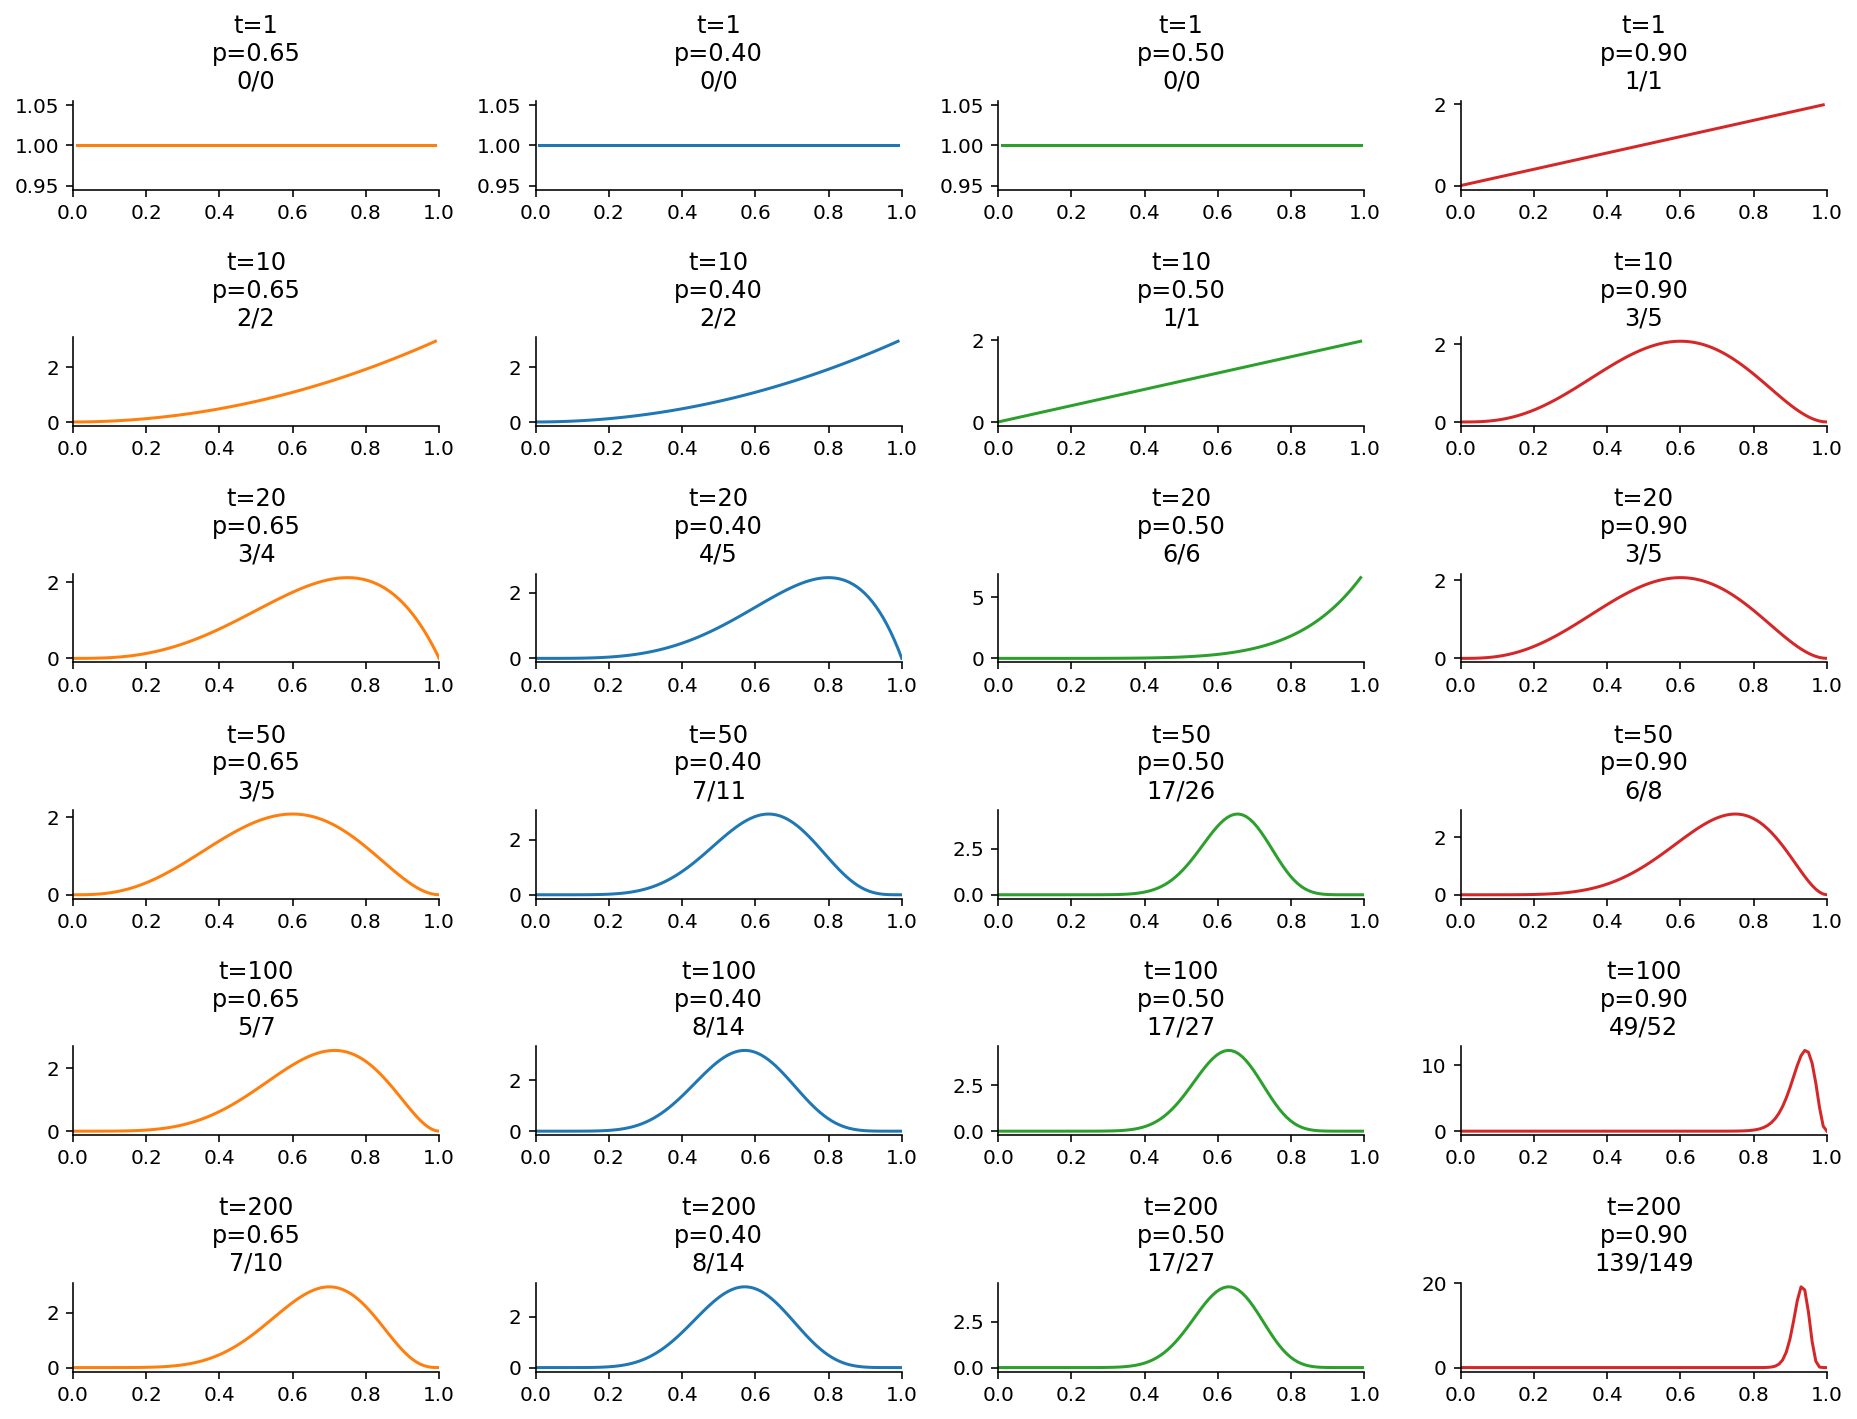

In [7]:
colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]
# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = alpha_hist[t, k].item() - 1
        n_trials = beta_hist[t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={probs[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

## A better API

In [6]:
from functools import partial

class BetaBernoulliBandits:
    def __init__(self, K):
        self.K = K
        
    def sample(self, key, params):
        alphas = params["alpha"]
        betas = params["beta"]
        params_sample = random.beta(key, alphas, betas)
        return params_sample
    
    def predict_rewards(self, params_sample):
        return params_sample
            
    def update(self, action, params, reward):
        alphas = params["alpha"]
        betas = params["beta"]
        # Update policy distribution
        ind_vector = one_hot(action, self.K)
        alphas_posterior = alphas + ind_vector * reward
        betas_posterior = betas + ind_vector * (1 - reward)
        return {
            "alpha": alphas_posterior,
            "beta": betas_posterior
        }


def true_reward(key, action, mean_rewards):
    """
    Reward after taking an action
    """
    reward = random.bernoulli(key, mean_rewards[action])
    return reward
    

def thompson_sampling_step(model_params, key, model, environment):
    """
    Context-free implementation of the Thompson sampling algorithm.
    This implementation considers a single step
    
    Parameters
    ----------
    model_params: dict
    environment: function
    key: jax.random.PRNGKey
    moidel: instance of a Bandit model
    """
    key_sample, key_reward = random.split(key)
    params = model.sample(key_sample, model_params)
    pred_rewards = model.predict_rewards(params)
    action = pred_rewards.argmax()
    # environment
    reward = environment(key_reward, action)
    model_params = model.update(action, model_params, reward)
    
    prob_arm = model_params["alpha"] / (model_params["alpha"] + model_params["beta"])
    
    return model_params, (model_params, prob_arm)

T = 200
key = random.PRNGKey(31415)
keys = random.split(key, T)
mean_rewards = jnp.array([0.4, 0.5, 0.2, 0.9])
K = len(mean_rewards)
bbbandit = BetaBernoulliBandits(mean_rewards)
init_params = {"alpha": jnp.ones(K),
               "beta": jnp.ones(K)}

environment = partial(true_reward, mean_rewards=mean_rewards)
thompson_partial = partial(thompson_sampling_step,
                           model=BetaBernoulliBandits(K),
                           environment=environment)
posteriors, (hist, prob_arm_hist) = jax.lax.scan(thompson_partial, init_params, keys)
prob_arm_hist = jnp.r_[jnp.ones((1, K)) * 0.5, prob_arm_hist]

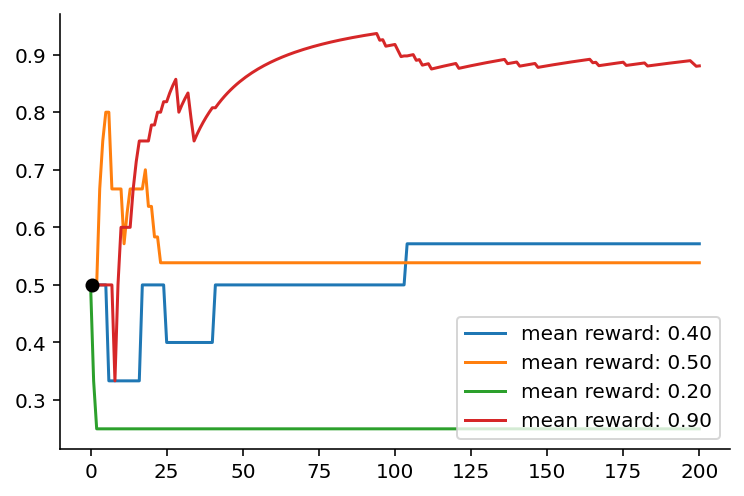

In [7]:
plt.plot(prob_arm_hist)
plt.scatter(0.5, 0.5, zorder=3, c="black")
plt.legend([f"mean reward: {reward:0.2f}" for reward in mean_rewards], loc="lower right")

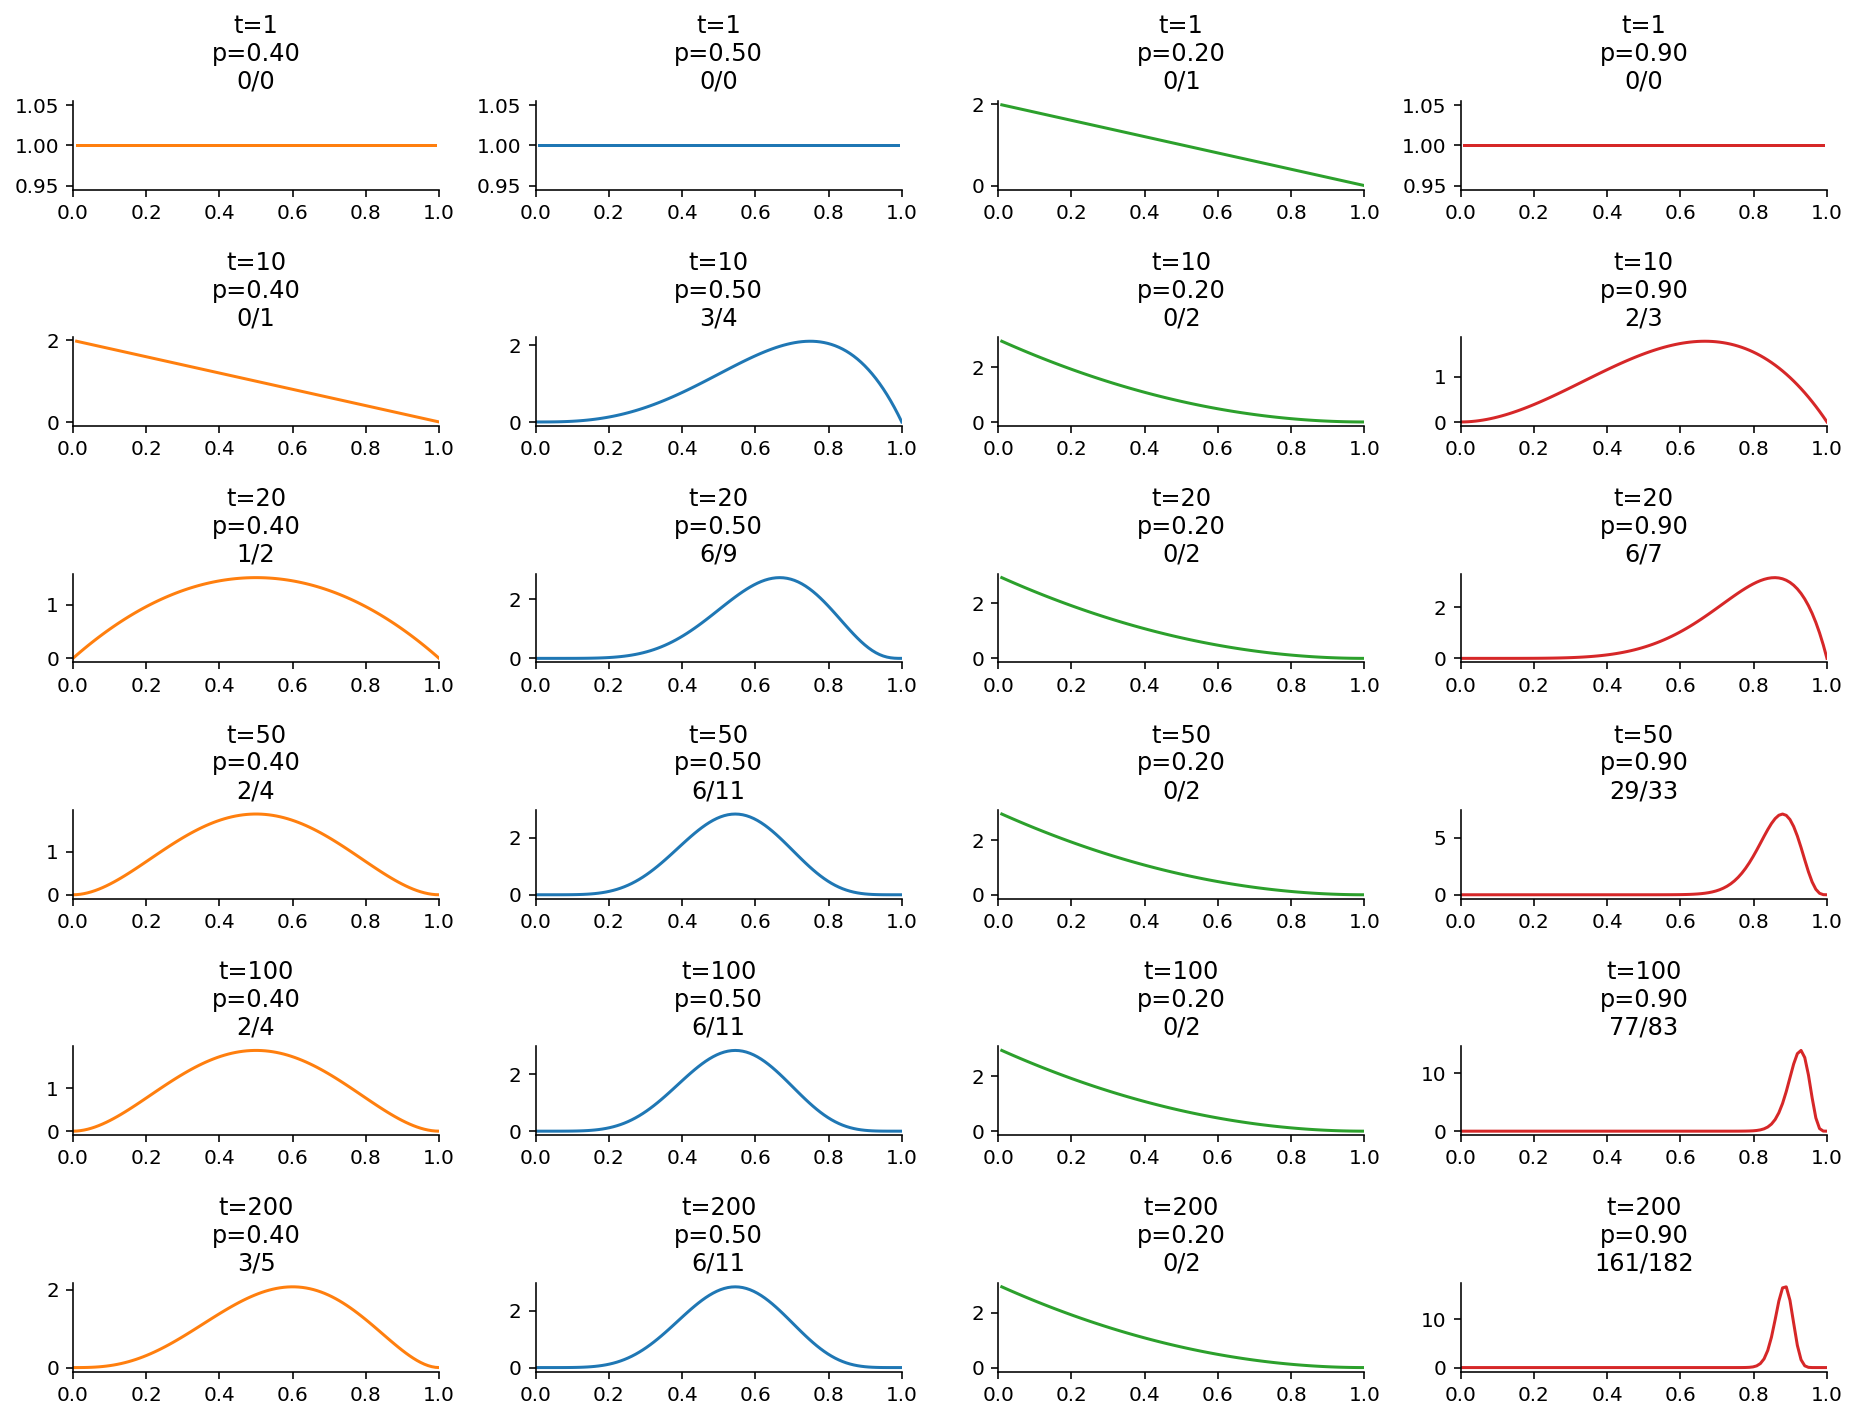

In [8]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], hist["alpha"][None, ...], hist["beta"][None, ...])
colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]

# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = hist["alpha"][t, k].item() - 1
        n_trials = hist["beta"][t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={mean_rewards[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

# Contextual multiarmed Normal bandit
## Linear case

In [9]:
import seaborn as sns
from jax.ops import index_update
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


In [10]:
class NormalGammaBandit:
    
    def sample(self, key, params, state):
        ...
    
    
    def predict_rewards(self, params_sample):
        ...
    
    
    def update(selc, action, params, reward):
        ...
        

def true_reward(self, key, action):
        ...

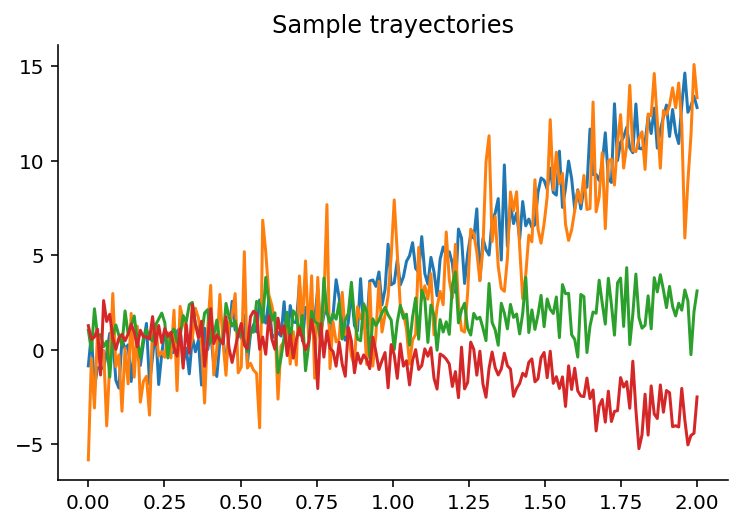

In [179]:
W = jnp.array([
    [-0.5, 1.0, 3.0],
    [-0.5, 0.7, 3.0],
    [1.0,  0.0, 0.5],
    [1.0, -0.3, -1.0]
])

sigmas = jnp.array([1.0, 5.0, 1.0, 1.0])
K, M = W.shape

N = 200
x = jnp.linspace(0, 2, N)
X = jnp.c_[jnp.ones(N), x, x ** 2]

true_params = {
    "w": W,
    "sigma2": sigmas ** 2
}

noise = random.multivariate_normal(key, mean=jnp.zeros(K), cov=jnp.eye(K) * sigmas, shape=(N,))
Y = jnp.einsum("nm,km->nk", X, W) + noise

plt.plot(x, Y)
plt.title("Sample trayectories");

In [180]:
class NormalGammaBandit:
    def sample(self, key, params, state):
        key_sigma, key_w = random.split(key, 2)
        sigma2_samp = tfd.InverseGamma(concentration=params["a"], scale=params["b"]).sample(seed=key_sigma)
        cov_matrix_samples = sigma2_samp[:, None, None] * params["Sigma"]
        w_samp = tfd.MultivariateNormalFullCovariance(loc=params["mu"], covariance_matrix=cov_matrix_samples).sample(seed=key_w)
        return sigma2_samp, w_samp
        
    def predict_rewards(self, params_sample, state):
        sigma2_samp, w_samp = params_sample
        predicted_reward = jnp.einsum("m,km->k", state, w_samp)
        return predicted_reward
        
    def update(self, action, params, state, reward):
        params = dict(params)
        mu = params["mu"]
        Sigma = params["Sigma"]
        a = params["a"]
        b = params["b"]
        
        mu_k = mu[action]
        Sigma_k = Sigma[action]
        Lambda_k = jnp.linalg.inv(Sigma_k)
        a_k = a[action]
        b_k = b[action]
        
        # weight params
        Lambda_update = jnp.outer(state, state) + Lambda_k
        Sigma_update = jnp.linalg.inv(Lambda_update)
        mu_update = Sigma_update @ state * reward
        # noise params
        a_update = a_k + 1/2
        b_update = b_k + (reward ** 2 + mu_k.T @ Lambda_k @ mu_k - mu_update.T @ Lambda_update @ mu_update) / 2
        
        mu = index_update(mu, action, mu_update)
        Sigma = index_update(Sigma, action, Sigma_update)
        a = index_update(a, action, a_update)
        b = index_update(b, action, b_update)
        
        params = {
            "mu": mu,
            "Sigma": Sigma,
            "a": a,
            "b": b
        }
        
        return params
    

def true_reward(key, action, state, true_params):
    # This can also be fetching from a known database in
    # which rewards are already known
    w_k = true_params["w"][action]
    sigma_k = jnp.sqrt(true_params["sigma2"][action])
    reward = w_k @ state + random.normal(key) * sigma_k
    return reward


def thompson_sampling_step(model_params, state, model, environment):
    """
    Contextual implementation of the Thompson sampling algorithm.
    This implementation considers a single step
    
    Parameters
    ----------
    model_params: dict
    environment: function
    key: jax.random.PRNGKey
    moidel: instance of a Bandit model
    """
    key, context = state
    key_sample, key_reward = random.split(key)
    params = model.sample(key_sample, model_params, context)
    pred_rewards = model.predict_rewards(params, context)
    action = pred_rewards.argmax()
    # environment reward
    reward = environment(key_reward, action, context)
    model_params = model.update(action, model_params, context, reward)
    
    arm_reward = one_hot(action, K) * reward
    return model_params, (model_params, arm_reward)

In [181]:
M = 3
eta = 3.0
lmbda = 2.0

# test state
state = random.normal(key, (M,))
init_params = {
    "mu": jnp.zeros((K, M)),
    "Sigma": lmbda * jnp.eye(M) * jnp.ones((K, 1, 1)),
    "a": eta * jnp.ones(K),
    "b": eta * jnp.ones(K),
}

In [182]:
key = random.PRNGKey(31415)
keys = random.split(key, N)

environment = partial(true_reward, true_params=true_params)
thompson_partial = partial(thompson_sampling_step,
                           model=NormalGammaBandit(),
                           environment=environment)


posteriors, (hist, hist_reward) = jax.lax.scan(thompson_partial, init_params, (keys, X))

posteriors["mu"]

DeviceArray([[ 0.4081, -1.84  ,  1.1892],
             [ 0.2772, -1.3981,  0.9742],
             [ 0.0397, -0.4214,  0.3513],
             [-0.0085,  1.0221, -1.3097]], dtype=float32)

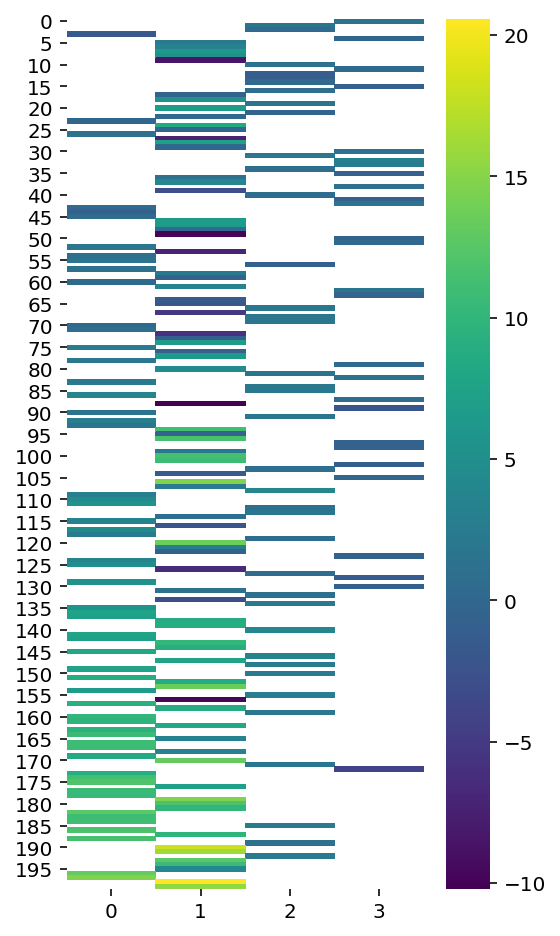

In [211]:
map_reward = hist_reward.copy()
map_reward = index_update(map_reward, map_reward==0, jnp.nan)

fig, ax = plt.subplots(figsize=(4, 8))
sns.heatmap(map_reward, cmap="viridis", ax=ax);

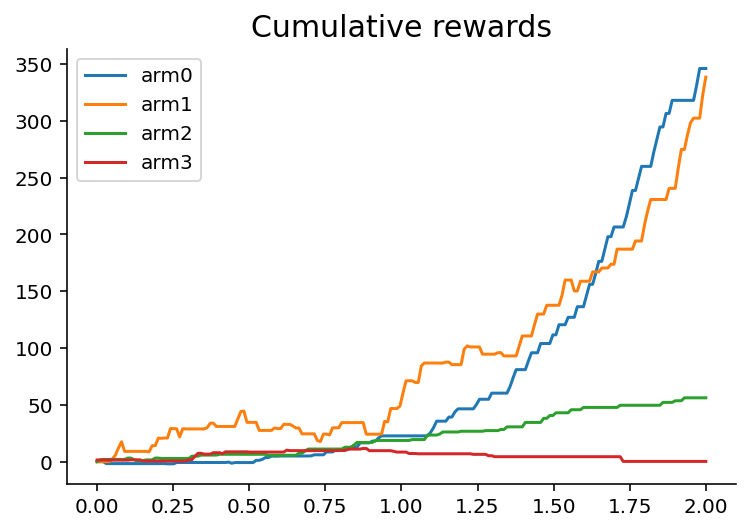

In [183]:
plt.plot(x, hist_reward.cumsum(axis=0))
plt.legend([f"arm{i}" for i in range(K)])
plt.title("Cumulative rewards", fontsize=15);

In [146]:
true_params["w"]

DeviceArray([[-0.5,  1. ,  3. ],
             [-0.5,  1. ,  3. ],
             [ 1. ,  0. ,  0.5],
             [ 1. , -0.3, -1. ]], dtype=float32)

## References
* https://github.com/ofirnabati/Neural-Linear-Bandits-with-Likelihood-Matching
* https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
* [Linear full posterior sampling](https://github.com/ofirnabati/Neural-Linear-Bandits-with-Likelihood-Matching/blob/main/bandits/algorithms/linear_full_posterior_sampling.py#L83-L123)

**Tensorflow stuff**
* https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX